In [1]:
%matplotlib notebook

In [2]:
import numpy as np
# -------------------------------------------------------------------------
# Const
# -------------------------------------------------------------------------
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180
pn=101000.  # Atmospheric pressure [N/m^2] (101KPa - enviromental pressure)

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

maxR=500.e3  # maximum radius of TC [m] (500Km)

In [4]:
import pandas
import matplotlib.pyplot as plt
from readbufr import read_bufr
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap

In [5]:
from getmedf import *

ImportError: No module named getmedf

In [5]:
path='/mnt/ECMWF/grib/'

# ANALYSIS STARTS HERE

In [6]:
hurName='ROANU'

In [7]:
tc=read_bufr(hurName)

In [8]:
print sorted(tc.keys())

['201605191200', '201605200000', '201605201200', '201605210000', '201605211200']


In [9]:
stamp=sorted(tc.keys())[2]

In [10]:
date=datetime.datetime.strptime(stamp,'%Y%m%d%H%S')
date

datetime.datetime(2016, 5, 20, 12, 0)

In [11]:
infile=path+'{}/{:02d}/{:02d}/{}.tropical_cyclone.grib'.format(date.year,date.month,date.day,datetime.datetime.strftime(date,'%Y%m%d.%H'))

In [12]:
yyyy=date.year
mm=date.month
dd=date.day
hh=12 # 0 or 12

In [13]:
# available in bufr 
print tc[stamp].t

[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.]


## CHOOSE forecast time

In [14]:
nt=0 # number of forecasts every hour, maximum 72

In [15]:
# choose center of vortex
itc=np.abs(tc[stamp].t-nt).argmin()
print itc

0


In [16]:
ni=71
nj=71
lon0=tc[stamp].plons[itc]-5.
lon1=tc[stamp].plons[itc]+5.
lat0=tc[stamp].plats[itc]-5.
lat1=tc[stamp].plats[itc]+5.

In [17]:
print lon0,lon1
print lat0,lat1

81.4 91.4
14.7 24.7


In [18]:
m = Basemap(projection='cyl',llcrnrlat=lat0,urcrnrlat=lat1,\
             llcrnrlon=lon0,urcrnrlon=lon1,resolution='l')
parallels = np.arange(-90.,90,20.)
meridians = np.arange(0.,360.,20.)

In [19]:
p,u,v,lon,lat = wmap(yyyy,mm,dd,hh,0,3*(nt+1),lon0,lon1,lat0,lat1,ni,nj)

0
1
2


In [20]:
it=nt

In [21]:
[[pi,pj]]=np.argwhere(p[it,:,:]==p[it,:,:].min()) # point of minimum pressure

<IPython.core.display.Javascript object>


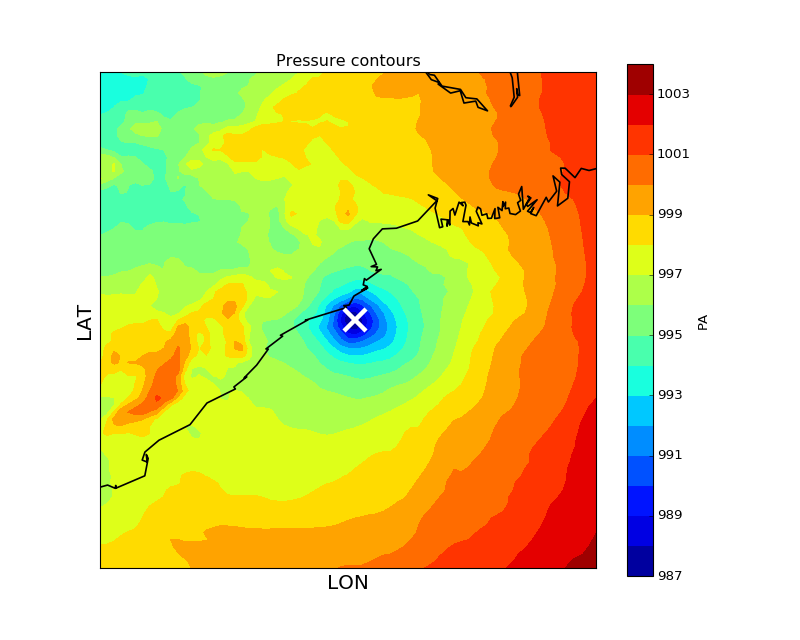

In [22]:
plt.figure(figsize=(10,8))
plt.contourf(lon,lat,p[it,:,:],20)
plt.plot(lon[pi,pj],lat[pi,pj],'kx',markersize=20, color='w', mew=4)
plt.colorbar(label='PA')
plt.xlabel('LON',fontsize=18)
plt.ylabel('LAT',fontsize=18)
plt.title('Pressure contours')

m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)

plt.show()

<IPython.core.display.Javascript object>


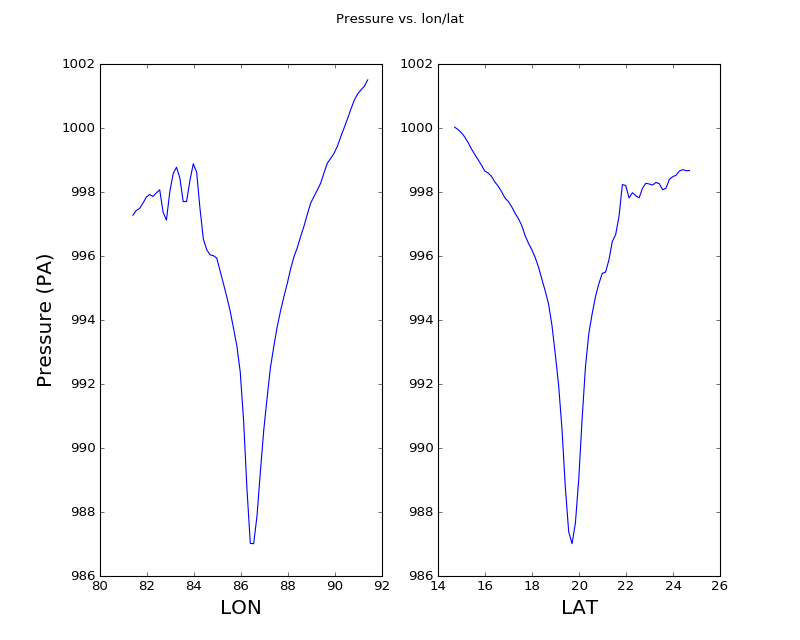

In [23]:
fig=plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(121)
ax1.plot(lon[0,:],p[it,pi,:],label='horizontal')
ax2 = fig.add_subplot(122)
ax2.plot(lat[:,pj],p[it,:,pj],label='vertical')
ax1.set_xlabel('LON',fontsize=18)
ax2.set_xlabel('LAT',fontsize=18)

ax1.set_ylabel('Pressure (PA)',fontsize=18)
fig.suptitle('Pressure vs. lon/lat')

plt.show()

In [24]:
vel=np.sqrt(u[it,:,:]**2+v[it,:,:]**2)

<IPython.core.display.Javascript object>


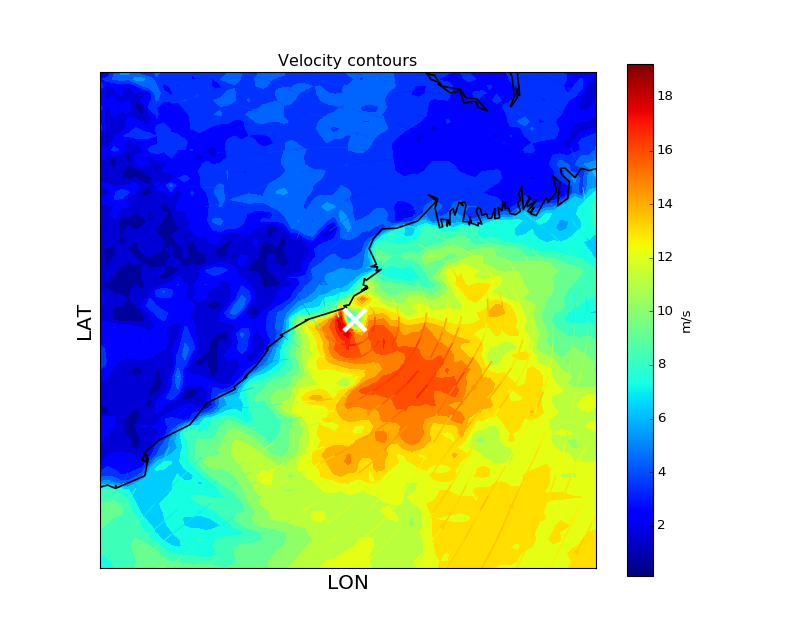

In [25]:
plt.figure(figsize=(10,8))
plt.contourf(lon,lat,vel,20)
plt.streamplot(lon,lat,u[it,:,:],v[it,:,:], color=vel, linewidth=0.1*vel)
plt.plot(lon[pi,pj],lat[pi,pj],'kx',markersize=20, color='w', mew=4)

plt.xlabel('LON',fontsize=18)
plt.ylabel('LAT',fontsize=18)
plt.title('Velocity contours')

plt.colorbar(label='m/s')

m.drawcoastlines(linewidth=1.5)
m.drawparallels(parallels)
m.drawmeridians(meridians)


plt.show()

<IPython.core.display.Javascript object>


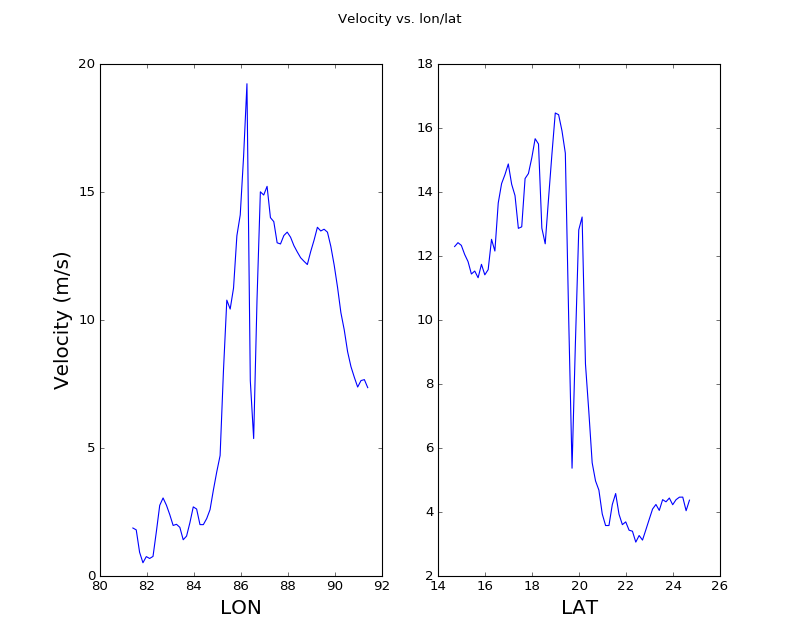

In [26]:
fig=plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(121)
ax1.plot(lon[0,:],vel[pi,:],label='horizontal')
ax2 = fig.add_subplot(122)
ax2.plot(lat[:,pj],vel[:,pj],label='vertical')
ax1.set_xlabel('LON',fontsize=18)
ax2.set_xlabel('LAT',fontsize=18)

ax1.set_ylabel('Velocity (m/s)',fontsize=18)
fig.suptitle('Velocity vs. lon/lat')

plt.show()

## from lat lon to meters

In [27]:
from math import radians, cos, sin, asin, sqrt
def Haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6378.388 * c
    return  km



In [28]:
# radial grid
th=np.linspace(0,2*np.pi,37)
rr=np.linspace(0.,3.,201) 
rad, the = np.meshgrid(rr,th)

In [29]:
rlon = rad * np.cos(the)
rlat = rad * np.sin(the)

In [30]:
### WE TRANSLATE THE RADIAL GRID TO THE ECMWF CENTER

nlon=rlon+lon[pi,pj]
nlat=rlat+lat[pi,pj]


In [31]:
## INTERPOLATE
pres = griddata((lon.ravel(),lat.ravel()), p[it,:,:].ravel(), (nlon,nlat), method='cubic')

In [32]:
pc=pres.reshape(37,201) # reshape to original (theta,rad) array


In [33]:
# translate to km
rec=[]
for x,y in zip(nlon.ravel(),nlat.ravel()):
  rec.append(Haversine(x,y, lon[pi,pj], lat[pi,pj]))

rec=np.array(rec)
rec=rec.reshape(37,201)

In [34]:
rrx=np.append(-rec[18,::-1],rec[0,:])
ppx=np.append(pc[18,::-1],pc[0,:])
rry=np.append(-rec[9,::-1],rec[27,:])
ppy=np.append(pc[9,::-1],pc[27,:])

<IPython.core.display.Javascript object>


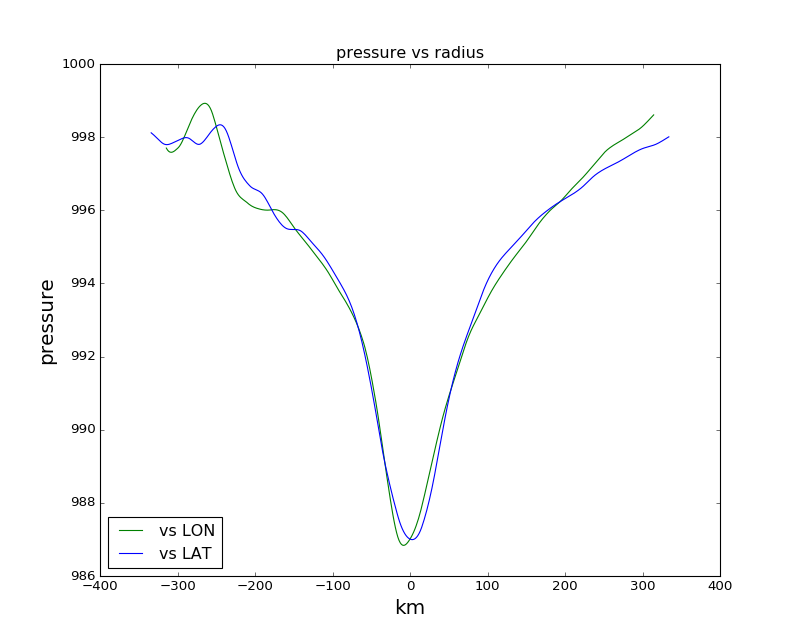

In [35]:
plt.figure(figsize=(10,8))

plt.plot(rrx,ppx,'g-',label='vs LON')
plt.plot(rry,ppy,'b-',label='vs LAT')

plt.xlabel('km',fontsize=18)
plt.ylabel('pressure',fontsize=18)
plt.title('pressure vs radius')

plt.legend(loc=0)

plt.show()

### for the velocity

In [36]:
## INTERPOLATE
vres = griddata((lon.ravel(),lat.ravel()), vel[:,:].ravel(), (nlon,nlat), method='cubic')

In [37]:
vc=vres.reshape(37,201) # reshape to original (theta,rad) array


In [38]:
vvx=np.append(vc[18,::-1],vc[0,:])
vvy=np.append(vc[9,::-1],vc[27,:])

<IPython.core.display.Javascript object>


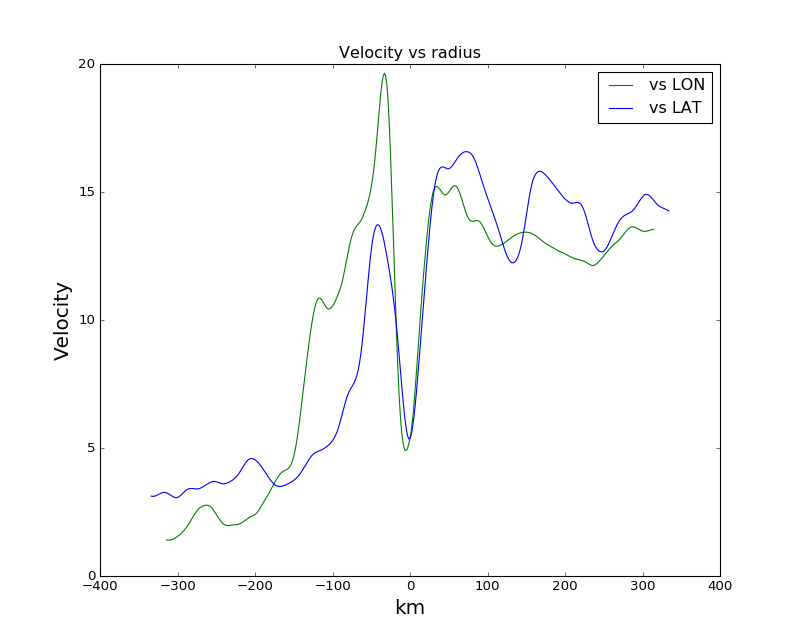

In [39]:
plt.figure(figsize=(10,8))

plt.plot(rrx,vvx,'g-',label='vs LON')
plt.plot(rry,vvy,'b-',label='vs LAT')

plt.xlabel('km',fontsize=18)
plt.ylabel('Velocity',fontsize=18)
plt.title('Velocity vs radius')

plt.legend(loc=0)


plt.show()

### superimpose the holland model

In [40]:
phol=np.loadtxt('tmp/phol')
uhol=np.loadtxt('tmp/uhol')
rhol=phol[0]
phol[1]=phol[1]/100 # convert to Pa

## Pressure

<IPython.core.display.Javascript object>


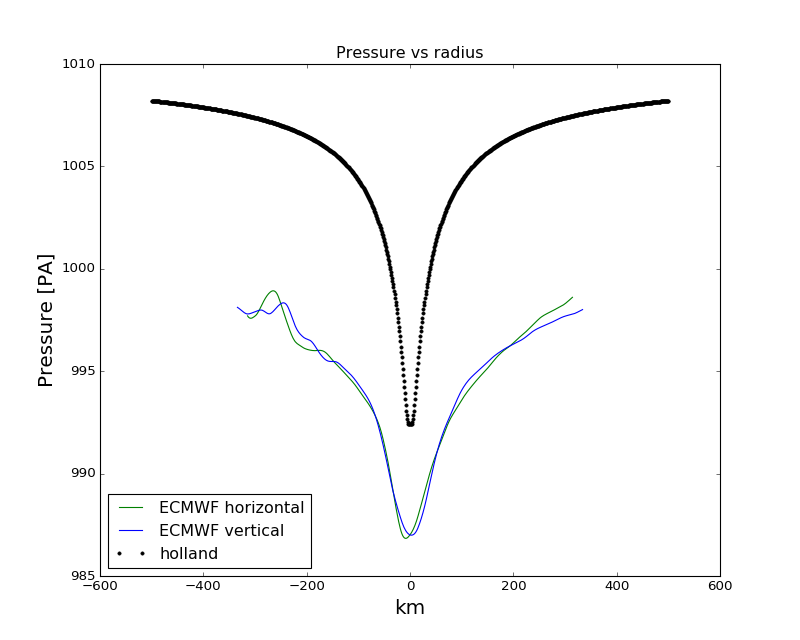

In [41]:
plt.figure(figsize=(10,8))

plt.plot(rrx,ppx,'g-',label='ECMWF horizontal')
plt.plot(rry,ppy,'b-',label='ECMWF vertical')
plt.plot(rhol/1000.,phol[1],'ko',markersize=3,label='holland')

plt.xlabel('km',fontsize=18)
plt.ylabel('Pressure [PA]',fontsize=18)
plt.title('Pressure vs radius')

plt.legend(loc=0)


plt.show()

## Velocity

<IPython.core.display.Javascript object>


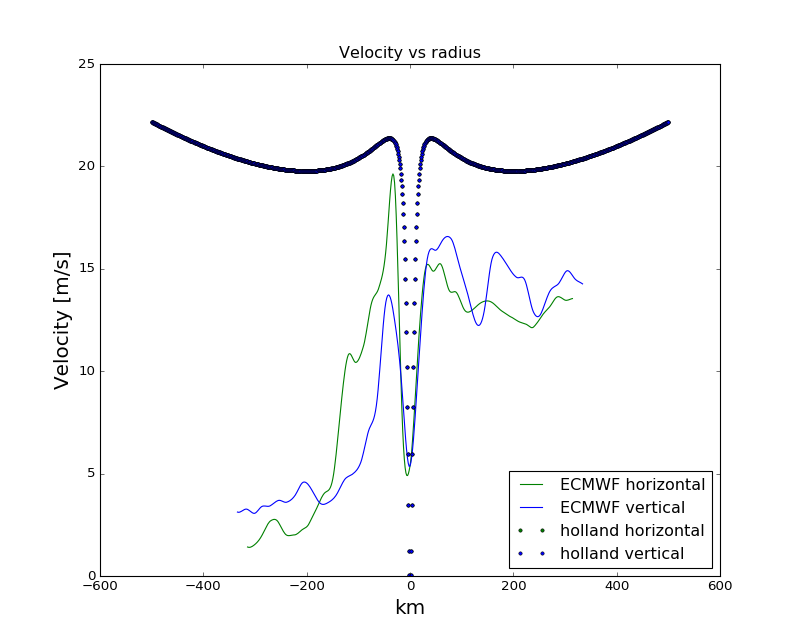

In [42]:
plt.figure(figsize=(10,8))

plt.plot(rrx,vvx,'g-',label='ECMWF horizontal')
plt.plot(rry,vvy,'b-',label='ECMWF vertical')
plt.plot(rhol/1000,uhol[1],'go',markersize=3,label='holland horizontal')
plt.plot(rhol/1000,uhol[2],'bo',markersize=3,label='holland vertical')

plt.xlabel('km',fontsize=18)
plt.ylabel('Velocity [m/s]',fontsize=18)
plt.title('Velocity vs radius')

plt.legend(loc=0)


plt.show()

In [43]:
pandas.DataFrame({'Min Pressure':[p[it,:,:].min()],'Max Velocity':[vel.max()]})

,Max Velocity,Min Pressure
0,19.228792,987.009283


In [44]:
np.savetxt('tmp/pecm',[rhol/1000.,phol[1]])
np.savetxt('tmp/uecm',[rhol/1000,uhol[1],uhol[2]])